<a href="https://colab.research.google.com/github/roveen001/trafficlightrecognition/blob/main/TrafficLightRecognition_final_v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import pandas as pd
import random as rn
from PIL import Image 
import seaborn as sns
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt 
from keras.optimizers import Adam
from keras import layers
from keras.regularizers import l1_l2
from mpl_toolkits.mplot3d import Axes3D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization


In [4]:
tlr_train = pd.read_csv('drive/MyDrive/archive/Train.csv',header = 0)
tlr_train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [5]:
# the task is identify the image from other measurements
# seperate feature/class, labels for traning 
# also the file path
tlr_features = tlr_train.copy()
tlr_labels = tlr_features.pop('ClassId')
tlr_file = tlr_features.pop('Path')
# convert to numpy array
tlr_features = np.asarray(tlr_features)

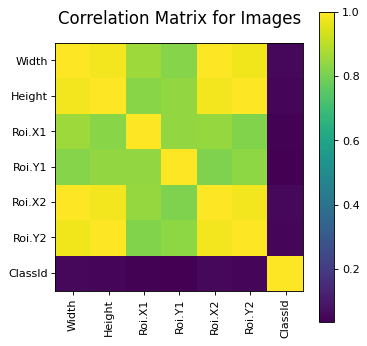

In [18]:
corr = tlr_train.corr()
plt.figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
corrMat = plt.matshow(corr, fignum = 1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.gca().xaxis.tick_bottom()
plt.colorbar(corrMat)
plt.title(f'Correlation Matrix for Images', fontsize=15)
plt.show()

In [17]:
# normalise the inputs to the model,
# keras normalzation fn tha precomputes the mean and variance of each column and uses it to normalise it

normalize = layers.Normalization()
normalize.adapt(tlr_features)
# after normalization

tlr_model = tf.keras.Sequential([
    normalize,
    layers.Dense(43),
    layers.Dense(1)
])
#model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

tlr_model.compile(loss=tf.keras.losses.MeanSquaredError(), metrics = ['accuracy'],
                  optimizer=tf.keras.optimizers.Adam())


history = tlr_model.fit(tlr_features,tlr_labels,epochs=100)

Epoch 1/100
1226/1226 [==============================] - 2s 2ms/step - loss: 192.9889 - accuracy: 0.0548
Epoch 2/100
1226/1226 [==============================] - 2s 2ms/step - loss: 143.8675 - accuracy: 0.0566
Epoch 3/100
1226/1226 [==============================] - 2s 2ms/step - loss: 143.8724 - accuracy: 0.0566
Epoch 4/100
1226/1226 [==============================] - 2s 2ms/step - loss: 143.8928 - accuracy: 0.0566
Epoch 5/100
1226/1226 [==============================] - 2s 2ms/step - loss: 143.8552 - accuracy: 0.0566
Epoch 6/100
1226/1226 [==============================] - 2s 1ms/step - loss: 143.8108 - accuracy: 0.0566
Epoch 7/100
1226/1226 [==============================] - 2s 2ms/step - loss: 143.7747 - accuracy: 0.0566
Epoch 8/100
1226/1226 [==============================] - 2s 2ms/step - loss: 143.8793 - accuracy: 0.0566
Epoch 9/100
1226/1226 [==============================] - 2s 2ms/step - loss: 143.8444 - accuracy: 0.0566
Epoch 10/100
1226/1226 [==============================]

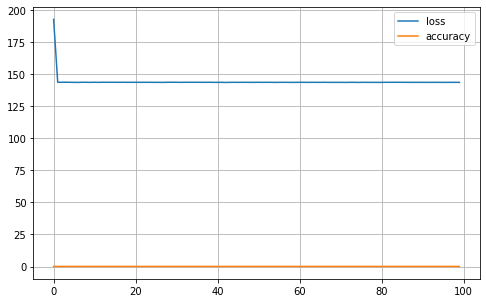

In [19]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)

# Train and Validataion 
## Using Keras Data Generators

In [11]:
BATCH_SIZE = 150  
HEIGHT, WIDTH = 224,224 
SEED = 2
CHANNELS = 3

# naming the classes
classes = {0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }


In [12]:
# lets define the output dir path
meta_dir = Path('drive/MyDrive/archive/Meta')
train_dir = Path('drive/MyDrive/archive/Train')
test_dir = Path('drive/MyDrive/archive/Test')

label_keys = list(classes.keys())
feature_labels = list(map(str, label_keys))


## Image pre-processing and **Augmentation** 

In [13]:
train_generator = ImageDataGenerator(rotation_range=90,
                                     validation_split=0.1,
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     rescale=1./255,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) 

In [14]:
traingen = train_generator.flow_from_directory(train_dir,
                                               target_size=(HEIGHT,WIDTH),
                                               class_mode='categorical',
                                               classes=feature_labels,
                                               interpolation='bilinear',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=SEED)

validgen = train_generator.flow_from_directory(train_dir,
                                               target_size=(HEIGHT,WIDTH),
                                               class_mode='categorical',
                                               classes=feature_labels,
                                               interpolation='bilinear',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=SEED)

testgen = test_generator.flow_from_directory(train_dir,
                                             target_size=(HEIGHT,WIDTH),
                                             class_mode='categorical',
                                             classes=feature_labels,
                                             interpolation='bilinear',
                                             batch_size=1, 
                                             shuffle=True,
                                             seed=SEED)

Found 35289 images belonging to 43 classes.
Found 3920 images belonging to 43 classes.
Found 39209 images belonging to 43 classes.


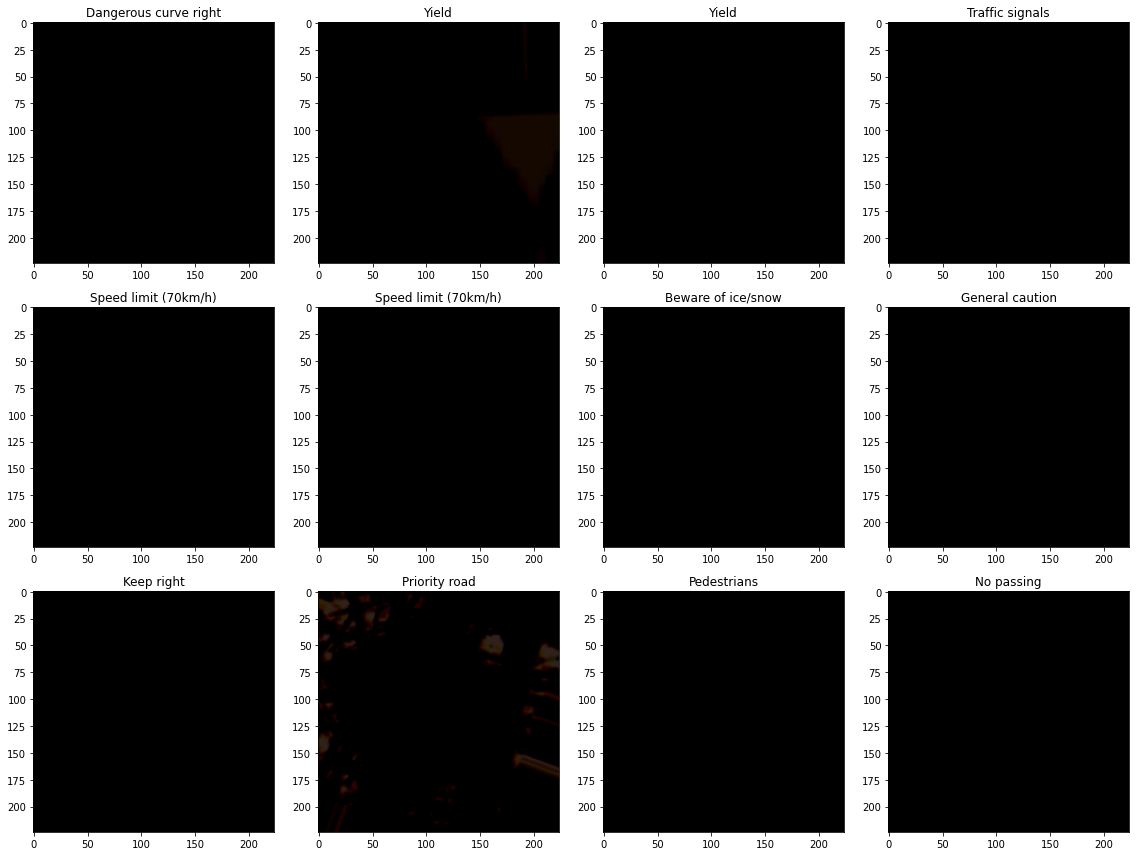

In [15]:
#display the images
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
img,y = traingen.next()
for i in range(3):
    for j in range (4):
        l=rn.randint(0,BATCH_SIZE-1)
        label = classes[int(list(traingen.class_indices.keys())[np.argmax(y[l])])]
        ax[i,j].imshow(img[l])
        ax[i,j].set_title(label)

plt.tight_layout()


# Feature Extraction


In [16]:
# creating model 
vgg16_model = Sequential([VGG16(weights='imagenet', include_top=False, 
                                       input_shape=(HEIGHT,WIDTH,3)),
                          BatchNormalization(),
                          Flatten(),
                          Dense(512, activation='relu'),
                          BatchNormalization(),
                          Dropout(rate=0.5),
                          Dense(43, activation='softmax')
                          ])

vgg16_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 512)        2048      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               12845568  
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 512)              

In [20]:
# loading the pre-trained model
OPTIM1=Adam(learning_rate=0.001)
NTRAIN_STEPS = traingen.samples // BATCH_SIZE 
NVALID_STEPS = validgen.samples // BATCH_SIZE 

EPOCHS = 8

#get the tranining model
vgg16_model.compile( optimizer=OPTIM1, loss='categorical_crossentropy', metrics=['accuracy'])

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')


In [19]:
# loading the pre-trained model
OPTIM1=Adam(learning_rate=0.001)
NTRAIN_STEPS = traingen.samples // BATCH_SIZE 
NVALID_STEPS = validgen.samples // BATCH_SIZE 

EPOCHS = 15
#NCLASSES = 43


# early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)
checkpointer = ModelCheckpoint(filepath='drive/myDrive/Colab Notebooks/weights.hdf5', 
                               verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)

#get the traning model
vgg16_model.compile(optimizer=OPTIM1, loss='categorical_crossentropy', metrics=['accuracy'])




In [20]:

len(traingen), NTRAIN_STEPS,len(validgen), NVALID_STEPS,traingen.samples // BATCH_SIZE 

(236, 235, 27, 26, 235)

In [ ]:
vgg_history=vgg16_model.fit(traingen,
          steps_per_epoch=NTRAIN_STEPS,
          validation_data=validgen,
          validation_steps=NVALID_STEPS,
          epochs=EPOCHS,
          callbacks = [checkpointer, early_stopping])

Epoch 1/5
 40/235 [====>.........................] - ETA: 10:59:34 - loss: 4.0965 - accuracy: 0.0447

In [4]:
# plotting the values obtained from the succesful code exectution
# taking really long time 
# could did it once never after that

vgg_history_c = pd.DataFrame({
    'loss':[3.3872,1.6818,1.0822,0.6545,0.3605,0.2369,0.1578,0.1158,0.1013,0.0527,0.0396,0.0305,0.0259,0.0388,0.0271],
    'val_loss':[25.5559,27.0457,40.4587,52.6746,49.0193,45.6912,37.0521,31.4948,20.3046,16.6583,2.8304,9.5822,5.0446,3.0341,3.8581],
    'accuracy':[0.2327,0.4749,0.6256,0.7701,0.8794,0.9178,0.9497,0.9614,0.9696,0.9836,0.9873,0.9907,0.9925,0.9862,0.9914],
    'val_accuracy':[0.0000e+00,0.2257,0.2257,0.2257,0.2257,0.2257,0.2257,0.2257,0.2257,0.2257,0.3222,0.2257,0.2470,0.3402,0.2917]
})

vgg_history_c

,loss,val_loss,accuracy,val_accuracy
0,3.3872,25.5559,0.2327,0.0000
1,1.6818,27.0457,0.4749,0.2257
2,1.0822,40.4587,0.6256,0.2257
3,0.6545,52.6746,0.7701,0.2257
4,0.3605,49.0193,0.8794,0.2257
5,0.2369,45.6912,0.9178,0.2257
6,0.1578,37.0521,0.9497,0.2257
7,0.1158,31.4948,0.9614,0.2257
8,0.1013,20.3046,0.9696,0.2257
9,0.0527,16.6583,0.9836,0.2257


<Figure size 1440x1080 with 0 Axes>

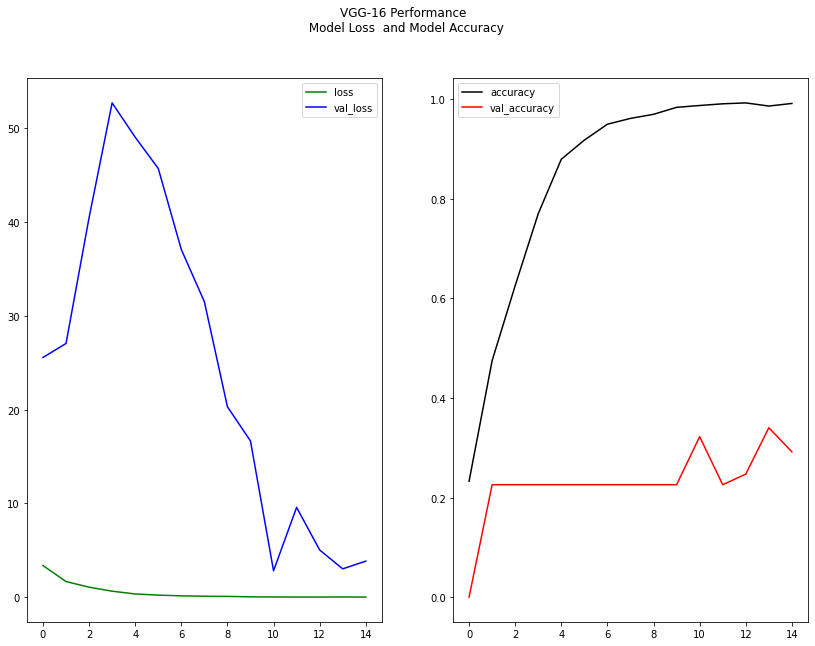

In [16]:
plt.figure(figsize=(20,15))
fig,ax=plt.subplots(1,2)
fig.set_size_inches(14,10)

  
vgg_history_c.plot(kind = 'line',
        y = 'loss',
        color = 'green', ax = ax[0])
  
vgg_history_c.plot(kind = 'line',
        y = 'val_loss',
        color = 'blue',ax = ax[0])
  
vgg_history_c.plot(kind = 'line',
        y = 'accuracy',
        color = 'black', ax = ax[1])
  
vgg_history_c.plot(kind = 'line',
        y = 'val_accuracy',
        color = 'red', ax=ax[1])

# set the title

fig.suptitle('VGG-16 Performance \n Model Loss  and Model Accuracy')
  
# show the plot
plt.show()

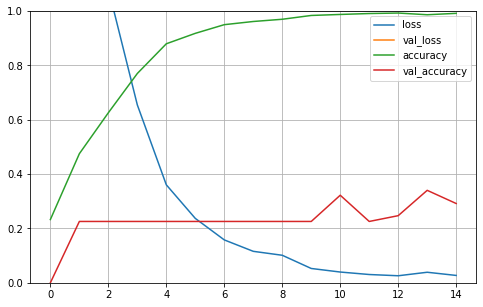

In [6]:
vgg_history_c.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()